# Face Recognition

The goal of this project is to design a basic face recognition system. 

## 1. Data Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

Display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images? Throw away all people for whom you have fewer than 10 images.

In [88]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline

In [2]:
import os
image_dir = 'lfw_funneled'

names = []
numImages = []

for f in os.listdir(image_dir):
    count = 0
    for i in os.listdir(image_dir+'/'+f):
        count += 1
    numImages.append(count)
    names.append(f)

Text(0,0.5,'Number of Individuals')

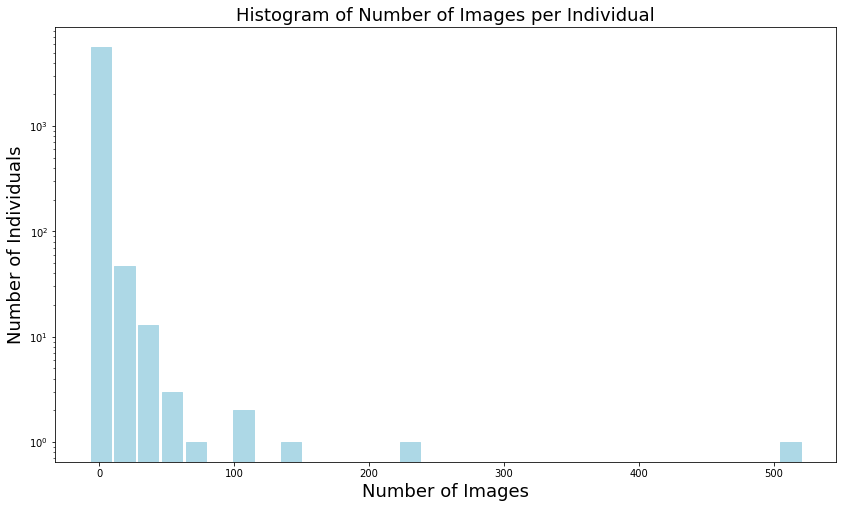

In [3]:
df = pd.DataFrame(numImages, index = names, columns = ['numofImages'])

plt.figure(figsize = (14,8))
plt.hist(numImages, Color = 'lightblue', bins = 30, align = 'left', rwidth = 0.85)
plt.yscale('log', nonposy = 'clip')
plt.title('Histogram of Number of Images per Individual', fontsize = 18)
plt.xlabel('Number of Images', fontsize = 18)
plt.ylabel('Number of Individuals', fontsize = 18)

In [4]:
df.sort_values('numofImages', ascending = False).head(10)

,numofImages
George_W_Bush,530
Colin_Powell,236
Tony_Blair,144
Donald_Rumsfeld,121
Gerhard_Schroeder,109
Ariel_Sharon,77
Hugo_Chavez,71
Junichiro_Koizumi,60
Jean_Chretien,55
John_Ashcroft,53


In [5]:
df10 = df[df['numofImages'] >= 10].copy()
print('There are', len(df10), 'individuals with 10 or more images.')

There are 158 individuals with 10 or more images.


### Section 1.1

### Answers:

The person with the most number of images is George W Bush, with a total of 530 images. 

After throwing away individuals with less than 10 images, we are left with 158 individuals. 

In [7]:
import os
image_dir = 'lfw_funneled'

images = []
j=0

for f in os.listdir(image_dir):
    if f in df10.index:
        for i in os.listdir(image_dir+'/'+f):
            images.append(mpimg.imread(image_dir+'/'+f+'/'+i))
images = np.asarray(images)

### 1.2. Show some faces!

1. Pick 8 random images from the dataset and display them in a 2 x 4 grid.
2. Create a single image that shows the "average face" -- i.e., each pixel should display the average value of that pixel across all of the images. 
3. For each pixel, calculate the standard deviation of values for that pixel (you will have a different standard deviation for each of the three color channels, feel free to just show the standard deviation of one of the channels, or to average the standard deviation of the three channels at each pixel). Plot these standard deviations as a heatmap.

What do you notice about the distribution of mean and standard deviation values in these images? (e.g., are they evenly distributed)

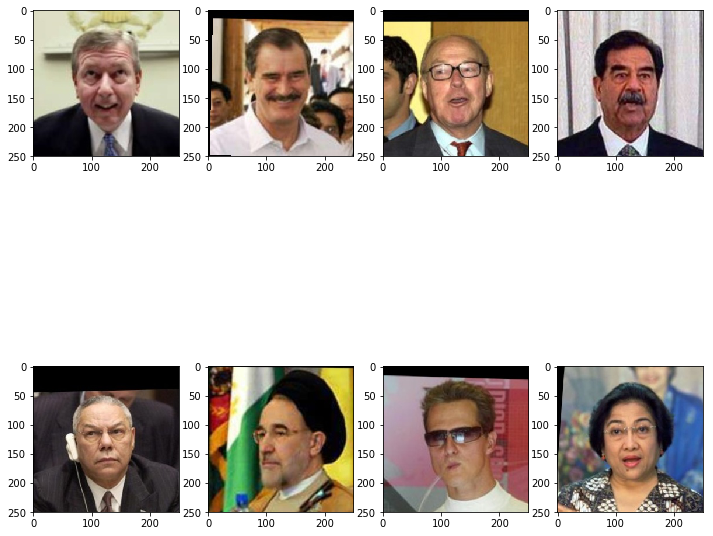

In [8]:
import random
random.seed(99)

display_index = np.random.choice(len(images),8)

j = 1
plt.subplots(figsize=(12,12))
for i in display_index:
    plt.subplot(2,4,j)
    plt.imshow(images[i])
    j+= 1

(250, 250, 3)


Text(0.5,1,'Average face of individuals with 10 or more images')

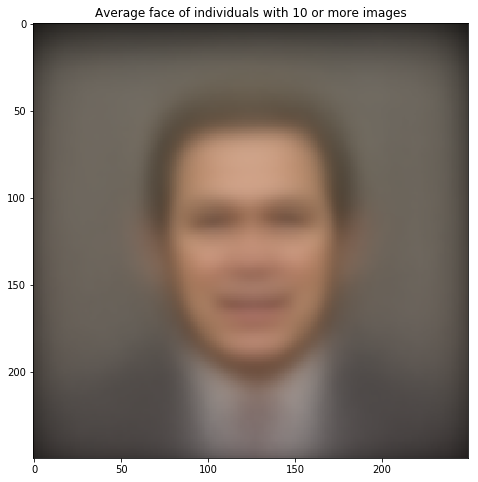

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
avg_images = np.mean(images, axis = 0).astype(np.uint8)
print(avg_images.shape)
plt.imshow(avg_images)
plt.title('Average face of individuals with 10 or more images')

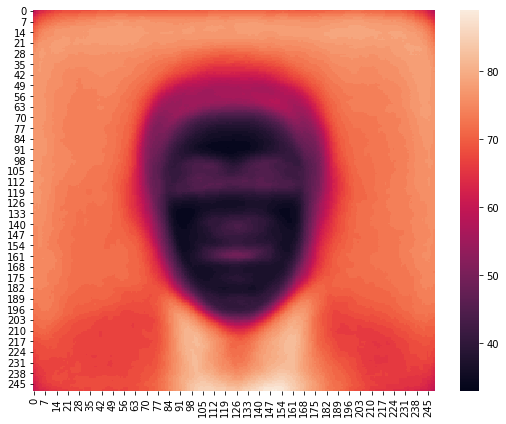

In [10]:
avg_std = np.around(np.mean(np.std(images, axis = 0), axis = 2), decimals = 0)
fig, ax = plt.subplots(figsize = (9,7))
sns.heatmap(avg_std)

### Section 1.2

### Answers:

As per instructed, the mean and standard deviation of the images were plotted. It is noted that the mean image resembles George W. Bush, which is expected given that his images alone account for 530 out of the total 4324.

As for the standard deviation heatmap of the images, it is observed that the "head region" experiences the least variation, which is expected given that most images contain centered faces with similar facial features (e.g. eyes, nose, mouth). Beyond this "head region", we see an increase in standard deviation because the backgrounds of different photos can vary greatly. 

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discuseed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [11]:
from sklearn.metrics import pairwise_distances_argmin
import random
random.seed(99)

def ClusterKM(X, k):
    # Randomly choose clusters
    centroids = InitializeCentroids(X,k)
    iteration = 0
    while True:
        print(iteration)
        iteration += 1
        # Assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids, k, idx)

        # Check for convergence
        if np.all(centroids == new_centroids):
            print('Number of iterations:', iteration)
            break
        centroids = new_centroids
    
    return centroids, idx

In [12]:
def InitializeCentroids(X,k):
    centroids = X[np.random.choice(len(X),k)]
    #a = np.random.uniform(low = np.min(X, axis = 0)[0], high = np.max(X, axis = 0)[0], size = k).reshape(k,1)
    #b = np.random.uniform(low = np.min(X, axis = 0)[1], high = np.max(X, axis = 0)[1], size = k).reshape(k,1)
    #centroids = np.concatenate((a,b), axis = 1)
    return centroids

In [13]:
def FindClosestCentroids(X, centroids):
    idx = pairwise_distances_argmin(X, centroids, axis = 1, metric='euclidean')
    return idx

In [14]:
def ComputeCentroidMeans(X, centroids, k, idx):
    new_centroids = np.zeros((k,X.shape[1]))
    for i in range(k):
        new_centroids[i,:] = np.mean(X[idx == i], axis = 0)
    return new_centroids

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. 

0
1
2
3
Number of iterations: 4


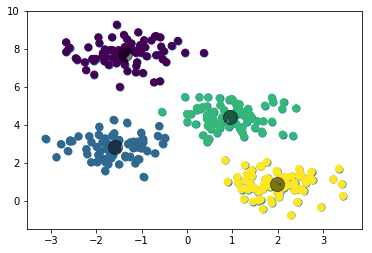

In [15]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50);

myCenters, myIdx = ClusterKM(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
plt.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5);

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=20. Make sure to normalize your data first! Show a 20 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250 x 250 x 3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is! -- it might take a long time for your algorithm to converge. If your computer is old, it might even take a very long time for you to simply normalize your data. If you are running into such problems, you may convert your RGB images into greyscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function).



In [16]:
from sklearn.preprocessing import StandardScaler

k = 20
images = images.reshape(len(images),250*250*3)

scaler_full = StandardScaler()
scaler_full.fit(images)
X = scaler_full.transform(images)

D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
norm_centroids, idx = ClusterKM(X, k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Number of iterations: 27


(20, 187500)


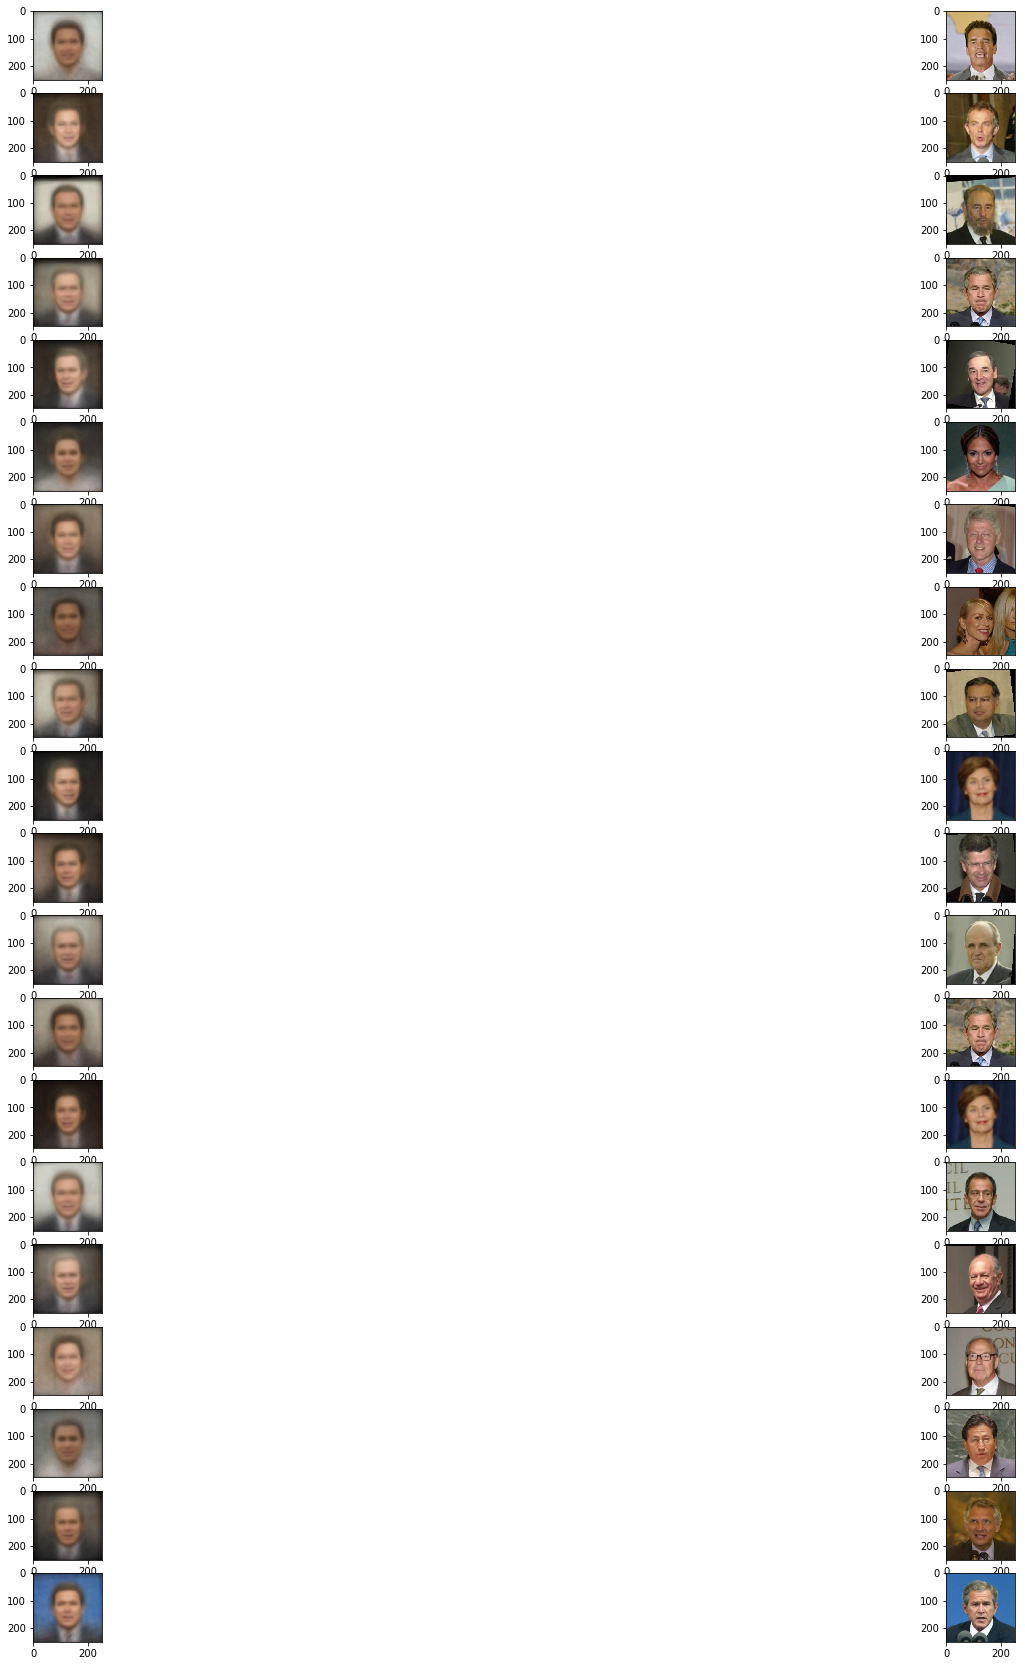

In [26]:
#images = images.reshape(len(images), 250 * 250 * 3)
#norm_centroids = reverse_normalize(centroids, images)

renorm_centroids = scaler_full.inverse_transform(norm_centroids)

#find images which are closest to the centroid images
closest_idx = pairwise_distances_argmin(renorm_centroids, images, axis = 1, metric='euclidean') 
closest_images = images[closest_idx]
print(closest_images.shape)
closest_images = closest_images.reshape(k, 250, 250, 3)
renorm_centroids = renorm_centroids.reshape(k, 250, 250, 3)


fig, ax = plt.subplots(figsize = (30,30))
for i in range(k):
    
    plt.subplot(20,2, 2*i + 1)
    plt.imshow(renorm_centroids[i].astype(np.uint8))
    
    plt.subplot(20,2, 2*i + 2)
    plt.imshow(closest_images[i].astype(np.uint8))

### Section 2.3

### Answers: 

Running the k-Means clustering algorithm with k = 20 on the images, we obtained 20 centroid images. These 20 centroid images are plotted in conjunction with the closest image (from the entire dataset) in the Euclidean distance sense. We note that 3 of the centroids are situated in the "George W. Bush cluster", which is expected given the high number of George W. Bush's photos. Other individuals with high number of photos, such as Tony Blair, are also featured above. 

It should be noted that the k-Means clustering algorithm is quite sensitive to the initial position of the centroids. As such, repeated simulations may yield rather varied results. 

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself
 2. The cluster centroid closest to that image
 3. The closest image in the original dataset to that cluster centroid
 4. The closest image in the original dataset to the image of yourself


Text(0.5,1,'My Image')

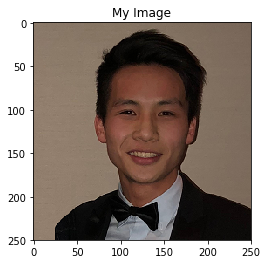

In [27]:
myImage = mpimg.imread('headshot.png')
plt.imshow(myImage)
plt.title('My Image')

Text(0.5,1,'Cluster Centroid Closest to My Image')

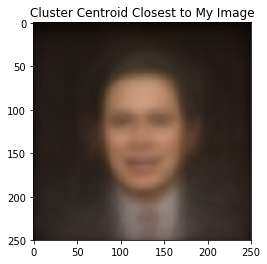

In [29]:
myImage = myImage.reshape(1, 250 * 250 * 3)

idx_me = pairwise_distances_argmin(myImage, renorm_centroids.reshape(k, 250 * 250 * 3), axis = 1, metric='euclidean')
similarImage = renorm_centroids[idx_me].reshape(250,250,3)
plt.imshow(similarImage.astype(np.uint8))
plt.title('Cluster Centroid Closest to My Image')

Text(0.5,1,'Closest Image in Dataset to Cluster Centroid')

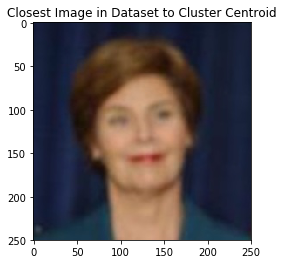

In [30]:
plt.imshow(closest_images[idx_me[0]].astype(np.uint8))
plt.title('Closest Image in Dataset to Cluster Centroid')

Text(0.5,1,'Closest Image to My Image')

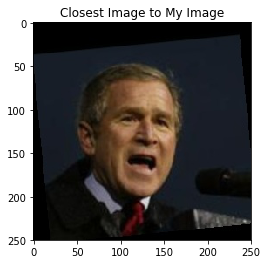

In [32]:
idx_all_me = pairwise_distances_argmin(myImage, images, axis = 1, metric='euclidean')
similarImageAll = images[idx_all_me].reshape(250,250,3)
plt.imshow(similarImageAll.astype(np.uint8))
plt.title('Closest Image to My Image')

## 3. PCA and Eigenfaces 

Begin by normalizing your data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [48]:
from sklearn.model_selection import train_test_split
import skimage.color as skc
from sklearn.preprocessing import StandardScaler

images = images.reshape(len(images), 250, 250, 3)
grey_images = skc.rgb2grey(images)
grey_images.shape

(4324, 250, 250)

In [49]:
grey_images = grey_images.reshape(len(grey_images), 250 * 250)

train, test = train_test_split(grey_images, test_size = 0.5, random_state = 99)

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

print('Original normalized data shape:', grey_images.shape)
print('Normalized train data shape:', train.shape)
print('Unnormalized test data shape:', test.shape)

#Note that we chose not to normalize the test data here so that it is easier to access the original test images in section 3.4

Original normalized data shape: (4324, 62500)
Normalized train data shape: (2162, 62500)
Unnormalized test data shape: (2162, 62500)


In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)
pca.fit(train)
print(pca.explained_variance_ratio_) 

[0.21924216 0.07305695 0.05528088 0.04212956 0.04004848 0.03638724
 0.02950056 0.01869074 0.01756955 0.01716031 0.01611774 0.01282166
 0.01187509 0.01141308 0.01068632 0.00934224 0.00923531 0.00790684
 0.00772839 0.00682677 0.00658275 0.00623601 0.00605723 0.00590588
 0.0051935  0.00497079 0.00482249 0.00463974 0.00436009 0.0042763
 0.0039249  0.00385693 0.00370113 0.00343017 0.00336255 0.00328778
 0.0031851  0.00310879 0.00296943 0.00292343 0.00286258 0.00277262
 0.00267938 0.00262961 0.00254287 0.00246019 0.00234157 0.0023312
 0.00229989 0.00225583 0.00219574 0.00212582 0.00210861 0.00206349
 0.00201606 0.00201086 0.00190885 0.00188484 0.00184703 0.00182343
 0.00178153 0.00173135 0.00171295 0.00167173 0.00164932 0.00160387
 0.0015804  0.00155792 0.00152054 0.001489   0.00147442 0.00143743
 0.00140801 0.00138476 0.00137222 0.00135567 0.00131085 0.00128915
 0.00127355 0.00124649 0.00121751 0.00120645 0.00118915 0.0011802
 0.00117813 0.00114586 0.00112148 0.0011071  0.0010862  0.0010721

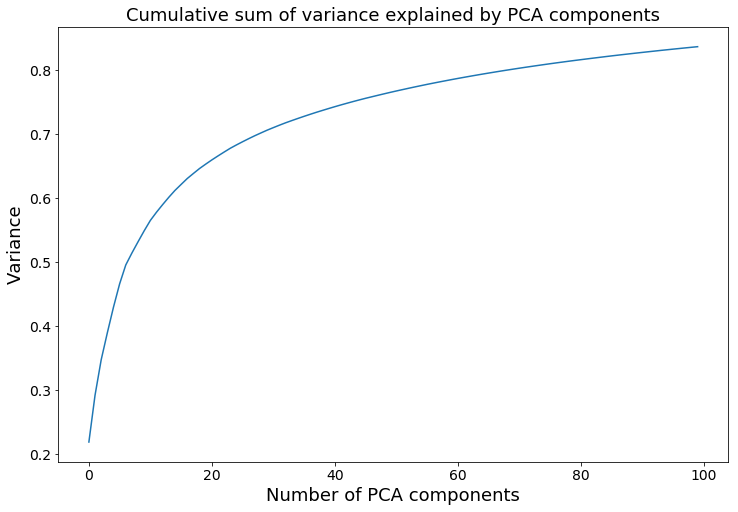

In [51]:
csum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(csum)
plt.title('Cumulative sum of variance explained by PCA components', fontsize = 18)
plt.xlabel('Number of PCA components', fontsize = 18)
plt.ylabel('Variance', fontsize = 18)
plt.tick_params(labelsize=14)

In [52]:
numofComponents = len(csum[csum <= 0.75]) + 1
print('We require', numofComponents, 'components to explain', np.around(csum[numofComponents] * 100, decimals = 2), '% of the variation in the data.')

We require 44 components to explain 75.33 % of the variation in the data.


### Section 3.1

### Answers:

As determined above, we require the 44 most significant components from the PCA implementation to explain at least 75% of the variation in the original data. 

Note that for Section 3, we use greyscale images instead of normal RGB images. 

### 3.2. Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

In [53]:
evalues = pca.singular_values_[0:10]
evectors = pca.components_[0:10]
print('Shape of eigenvalues:', evalues.shape)
print('Shape of eigenvectors:', evectors.shape)

Shape of eigenvalues: (10,)
Shape of eigenvectors: (10, 62500)


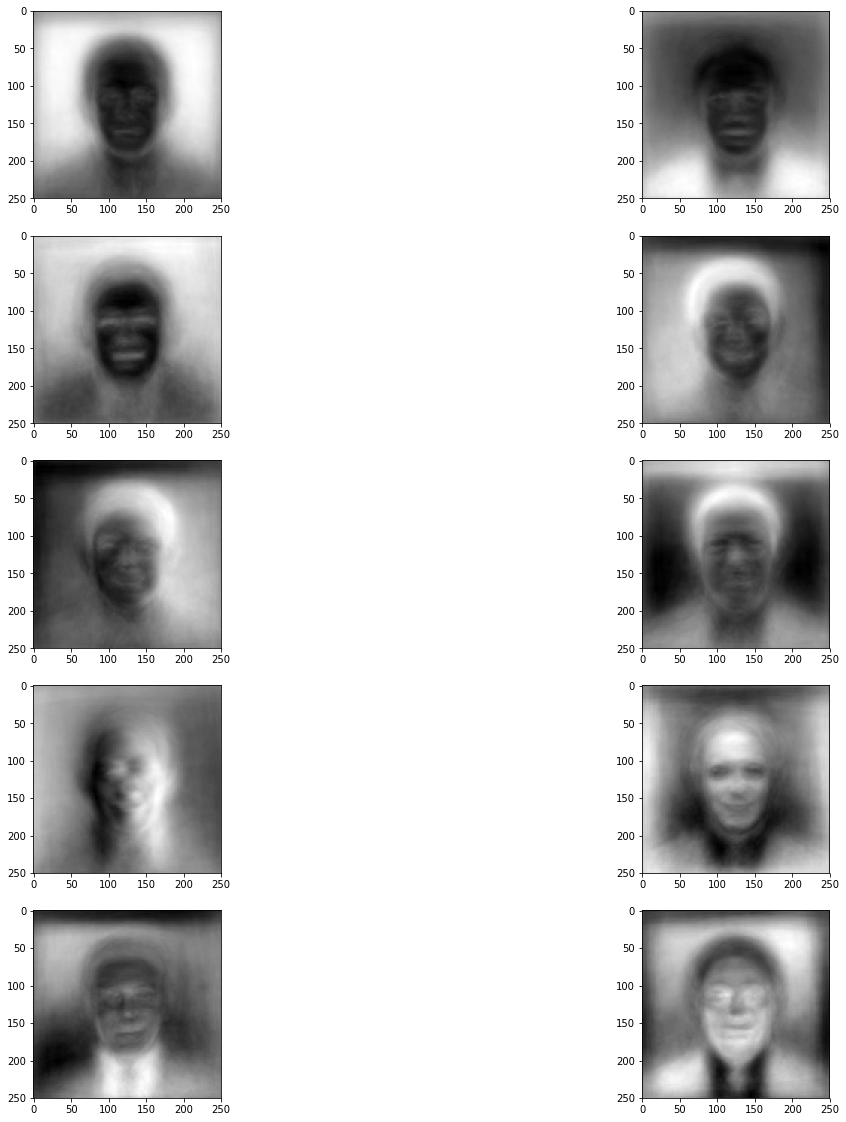

In [54]:
#efaces = reverse_normalize(evectors, images)
#efaces = efaces.reshape(10, 250, 250, 3)

#efaces = scaler.inverse_transform(evectors)
#efaces = efaces - np.mean(efaces, axis = 0).reshape(1, 250 * 250 * 3)
#efaces = efaces + np.mean(images, axis = 0)

efaces = evectors
efaces = efaces.reshape(10, 250, 250)
fig, ax = plt.subplots(figsize = (20,20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(efaces[i], cmap = plt.cm.gray)

### Section 3.2

### Answers:

The above shows the 10 eigenfaces obtained from the PCA. 

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 50-dimensional space defined by the first 50 principal components.
 - Apply k-means clustering, with k=20, to the 50-dimensional projections of the training data. 
 - Display a 4 x 5 grid of images that shows what each of the 20 centroids look like after the centroid is projected back into the original-image space.

In [55]:
evalues = pca.singular_values_[0:50]
evectors = pca.components_[0:50]
print('Shape of eigenvalues:', evalues.shape)
print('Shape of eigenvectors:', evectors.shape)
print('Shape of train set:', train.shape)
print('Shape of test set:', test.shape)

Shape of eigenvalues: (50,)
Shape of eigenvectors: (50, 62500)
Shape of train set: (2162, 62500)
Shape of test set: (2162, 62500)


In [64]:
k = 20

train_50 = np.matmul(train, evectors.T)

centroids_50, idx_50 = ClusterKM(train_50, k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
Number of iterations: 32


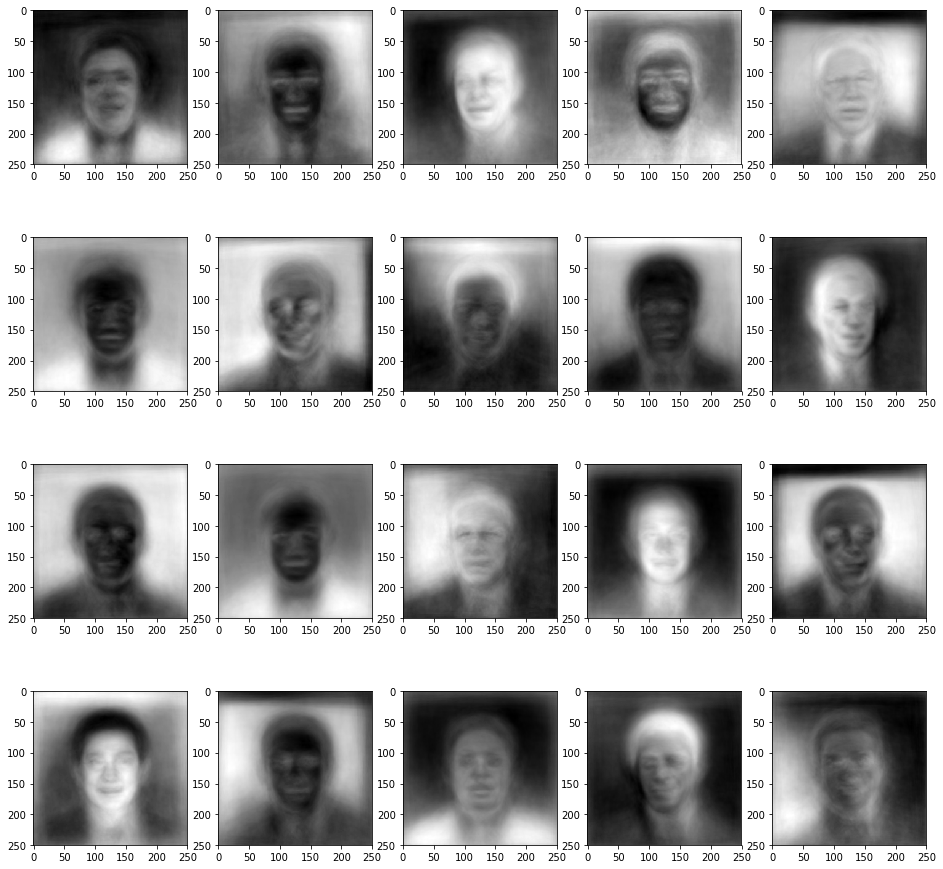

In [65]:
recon_centroids = np.matmul(centroids_50, evectors).reshape(k, 250, 250)

plt.subplots(figsize=(16,16))

for i in range(k):
    plt.subplot(4,5,i+1)
    plt.imshow(recon_centroids[i], cmap = plt.cm.gray)

### Section 3.3

### Answers:

For the above, we projected the training data into the 50-dimensional space defined by the most significant 50 principal components from PCA. Subsequently, k-Means clustering was implemented (k = 20) on the projected training data, and the resulting centroids were projected back to the original image space. These images are shown above. 

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

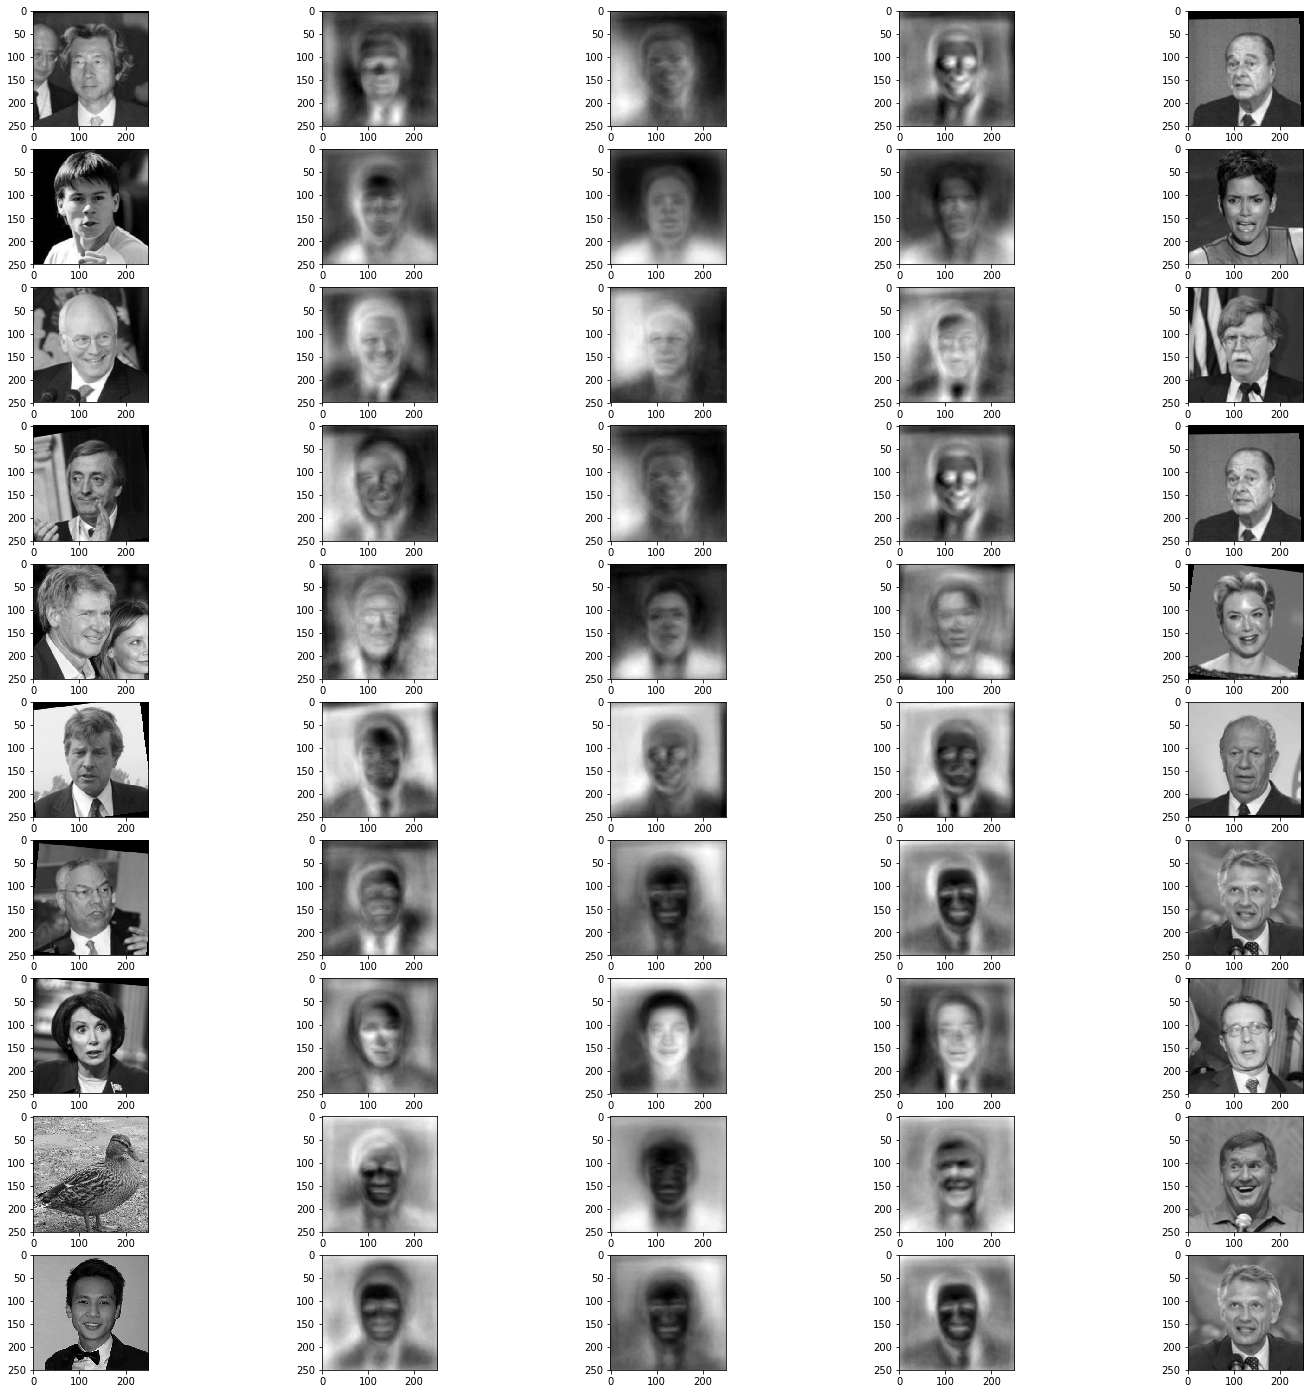

In [72]:
random_indices = np.random.choice(len(test),8)

# original images
random_8 = test[random_indices]
non_face = skc.rgb2grey(mpimg.imread('duckie.png')).reshape(1,250*250)
my_image = skc.rgb2grey(mpimg.imread('headshot.png')).reshape(1,250*250)
test_10 =  np.concatenate((random_8, non_face, my_image), axis = 0)

#o = np.matmul(test_50[random_indices], evectors).reshape(k, 250, 250)


# normalize the 10 selected images, project onto 50-d eigenface-space and reproject back to original image space
test_10_norm = scaler.transform(test_10)
test_10_50d = np.matmul(test_10_norm, evectors.T)
test_10_recon = np.matmul(test_10_50d, evectors)

# nearest centroid from section 3.3 to image
recon_centroids = recon_centroids.reshape(k, 250 * 250)
idx_recon_centroids = pairwise_distances_argmin(test_10_recon, recon_centroids, axis = 1, metric='euclidean')

# image in training data whose 50-d representation is closest to reconstructed centroid
recon_train = np.matmul(train_50, evectors)
idx_recon_train = pairwise_distances_argmin(recon_centroids[idx_recon_centroids], recon_train, axis = 1, metric='euclidean')

# original training image that was selected in step 4
original_train = scaler.inverse_transform(train)


fig, ax = plt.subplots(figsize = (25,25))
for i in range(10):
    plt.subplot(10,5,5*i+1)
    plt.imshow(test_10.reshape(10,250,250)[i], cmap = plt.cm.gray)
    plt.subplot(10,5,5*i+2)
    plt.imshow(test_10_recon.reshape(10,250,250)[i], cmap = plt.cm.gray)
    plt.subplot(10,5,5*i+3)
    plt.imshow(recon_centroids[idx_recon_centroids[i]].reshape(250,250), cmap = plt.cm.gray)
    plt.subplot(10,5,5*i+4)
    plt.imshow(recon_train[idx_recon_train[i]].reshape(250,250), cmap = plt.cm.gray)
    plt.subplot(10,5,5*i+5)
    plt.imshow(original_train[idx_recon_train[i]].reshape(250,250), cmap = plt.cm.gray)

### 3.5. (Extra credit) Share your results
Post the following to bCourses for people in the class to see:
 - The photo of yourself
 - The cluster centroid from 2.4 that is closest to that image
 - The closest image in the dataset to that cluster centroid
 - The reconstruction of your image after it has been projected and reprojected (i.e., #2 in 3.4)
 - The nearest centroid to the projection (i.e., #3 in 3.4)
 - The closest training image to that centroid (i.e., #5 in 3.4)

Text(0.5,1,'Training Image Closest to Closest Centroid')

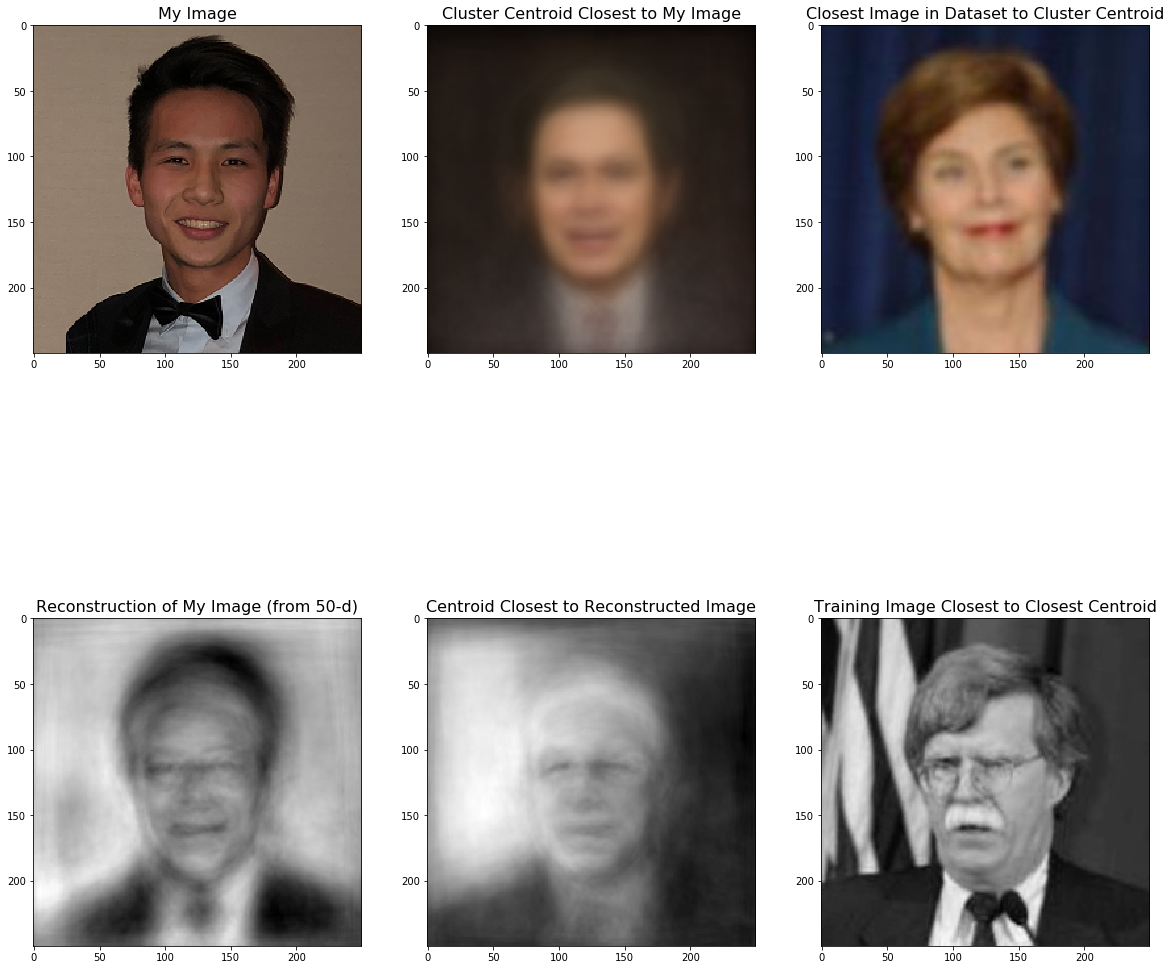

In [87]:
myImage = myImage.reshape(250, 250, 3)

#reconstruction of image after projecting to 50-d space
myImage_grey = skc.rgb2grey(myImage)
myImage_grey = myImage_grey.reshape(250*250)
myImage_50d = np.matmul(myImage_grey, evectors.T)
myImage_recon = np.matmul(myImage_50d, evectors)

# nearest centroid from section 3.3 to image
idx_myImage_centroid = pairwise_distances_argmin(myImage_recon.reshape(1,250*250), recon_centroids, axis = 1, metric='euclidean')

# image in training data whose 50-d representation is closest to reconstructed centroid
idx_myImage_train = pairwise_distances_argmin(recon_centroids[idx_myImage_centroid], recon_train, axis = 1, metric='euclidean')

fig, ax = plt.subplots(figsize = (20,20))

plt.subplot(2,3,1)
plt.imshow(myImage)
plt.title('My Image', fontsize = 16)
plt.subplot(2,3,2)
plt.imshow(similarImage.astype(np.uint8))
plt.title('Cluster Centroid Closest to My Image', fontsize = 16)
plt.subplot(2,3,3)
plt.imshow(closest_images[idx_me[0]])
plt.title('Closest Image in Dataset to Cluster Centroid', fontsize = 16)
plt.subplot(2,3,4)
plt.imshow(myImage_recon.reshape(250,250), cmap = plt.cm.gray)
plt.title('Reconstruction of My Image (from 50-d)', fontsize = 16)
plt.subplot(2,3,5)
plt.imshow(recon_centroids[idx_myImage_centroid].reshape(250,250), cmap = plt.cm.gray)
plt.title('Centroid Closest to Reconstructed Image', fontsize = 16)
plt.subplot(2,3,6)
plt.imshow(original_train[idx_myImage_train].reshape(250,250), cmap = plt.cm.gray)
plt.title('Training Image Closest to Closest Centroid', fontsize = 16)


### 3.6. (Extra extra credit) PCA Implementation

Implement PCA yourself, without using sklearn. How does the running time of your algorithm compare to the running time of the sklearn version?

In [ ]:
# Enter your code here

### 3.6. (Extra extra extra credit): Deep Learning
- Download the latest checkpoint of the pre-trained Inception model from TensorFlow
- Using the pretrained ConvNet, extract features for all of these images
- Redo parts 2.3 (b) and 2.4 (parts 1,3,4) of this problem set using the ConvNet features instead of the raw pixel values
- How do these results compare to the results in parts 2.3 and 2.4? Interpret!

*Your observations here*